<a href="https://colab.research.google.com/github/Seif-Tarek/Document-Similarity-using-Word-Mover-Distance/blob/master/WMD_TextSimilarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.metrics import classification_report,confusion_matrix,mean_squared_error,accuracy_score,roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression 
from gensim.models import KeyedVectors
from sklearn.externals import joblib 
import matplotlib.pyplot as  plt
from collections import Counter
from google.colab import drive
import pandas as pd
import numpy as np
import random
import string
import math
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Downloading Word2vec 

In [2]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

--2020-05-26 21:53:22--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.83.19
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.83.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  27.3MB/s    in 59s     

2020-05-26 21:54:21 (26.7 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## Reading the dataset
Read data from google drive that mounted before.

you can download the data from  https://drive.google.com/file/u/4/d/1CUPi6nri5u21DbVYr0MfHSOVOLS2TlYs/view?usp=drive_open.

In [3]:
data = pd.read_csv('drive/My Drive/DocumentSimilarity_Dataset.csv')
data = data.sample(frac=1).reset_index(drop=True)

data.head()

,articles,abstracts,similarity
0,"as viral videos go, ""gangnam style"" went gangb...","axelrod says ""it was a mistake"" for obama to s...",0
1,fueled by seasonal monsoon rains and a nearby ...,"eleven people die from landslide, electrocuti...",1
2,russian president dmitry medvedev said wednesd...,medvedev says the davos forum was considered ...,1
3,every year the brains behind your favorite rea...,"heads of production companies behind ""jersey s...",1
4,america is a less christian nation than it was...,new survey finds americans less likely to iden...,1


splitting the dataset 

In [0]:
size_of_training_data = 1200
f =  int(size_of_training_data/3)
def split(dt):
  size = len(dt)
  train = dt[:size_of_training_data,].reset_index(drop=True)
  val = dt[size_of_training_data:size_of_training_data+f,].reset_index(drop=True)
  test = dt[size_of_training_data+f:size_of_training_data+2*f,].reset_index(drop=True)
  return train,val,test

In [6]:
data = data.sample(frac=1).reset_index(drop=True)

train1 = data['articles'].astype('str')
train2 = data['abstracts'].astype('str')
labels = data['similarity']


article, article_val, article_test = split(train1)
summary, summary_val, summary_test = split(train2)
labels, val_label, test_label = split(labels)
print("size of training data : ",article.shape[0])
print("size of validating data : ",summary_val.shape[0])
print("size of testing data : ",test_label.shape[0])

size of training data :  1200
size of validating data :  400
size of testing data :  400


## Feature Engineering
#### 1. Cosine Similarity
Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them.

![Alt Text](https://i.imgur.com/HqKjGoQ.jpg)


#### 2. Word Mover's Distance
Word Mover's Distance (WMD) uses the word embeddings of the words in two texts to measure the minimum distance that the words in one text need to travel in semantic space to reach the words in the other text.

The WMD is measured by measuring the minimum euclidean distance between each word in the two documents in word2vec space. if the distance is small then words in the two documents are close to each other.

So, If I have the same two sentences:
- sentence 1: "Obama speaks to the media in Illinois"
- sentence 2: "The president greets the press in Chicago"

After removing stopwords, The word mover distance is small as mentioned in the figure.


![Alt Text](https://imgur.com/L1QNfPK.jpg)

In [0]:
WORD = re.compile(r"\w+")

def text_to_vector(text):
    '''
        converting the document to a term matrix where all words are listed and beside it the frequency of it.

        -- input:
                    text: the document as string 
        -- output:
                    Term matrix: Each word in the two documents and its frequency 
    '''
    words = WORD.findall(text)
    stopwords = nltk.corpus.stopwords.words('english')
    words = [w for w in words if w not in stopwords]
    return Counter(words)

def get_cosine(doc1, doc2):
    '''
        Get the cosine similarity between two documents.
        Depends on the angle between two non zero vectors which are constructed by each word frequency in the two documents.

        -- input:
                      doc1: the first document as string
                      doc2: the second document as string
        -- output:
                      cosine similarity score

    '''
    vec1 = text_to_vector(doc1)
    vec2 = text_to_vector(doc2)
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator
        
def wordMdistance(doc1,doc2):
  '''
      return the word mover distance between two documents 

      -- input:
                      doc1: the first document as list of words
                      doc2: the second document as list of words
      -- output:
                      Word Mover's Distance score
  '''
  sum_dist = 0
  i = 0
  for word in sent1:
    mindist = 1000.0
    for word2 in sent2:
      try:
        j = np.copy(word2vec.get_vector(word))
        t = np.copy(word2vec.get_vector(word2))
        dista = np.sqrt(sum((j-t)**2))
        if(dista < mindist):
          mindist = dista
      except:
        continue
    sum_dist+=mindist
    i+=1
  return sum_dist/i

def WMD(doc1,doc2):
  '''
      Preprocess the document first and remove english stopwords then call the function that calculates the word mover distance
     
      -- input:
                      doc1: the first document as string
                      doc2: the second document as string
      -- output:
                      Word Mover's Distance score
  '''
  first_doc = doc1.lower().split()
  second_doc = doc2.lower().split()
  stopwords = nltk.corpus.stopwords.words('english')
  first_doc = [w for w in first_doc if w not in stopwords]
  second_doc = [w for w in second_doc if w not in stopwords]
  return (word2vec.wmdistance(second_doc, first_doc))

*Extracting features from training data*

In [0]:
training = pd.DataFrame({"article":article,"summary":summary})
training['Cosine'] = training.apply(lambda row: get_cosine(row['article'],row['summary']), axis=1)
training['WMD'] = training.apply(lambda row: WMD(row['article'],row['summary']), axis=1)
del training['article']
del training['summary']

*Extracting features from validating data*

In [0]:
validation = pd.DataFrame({"article":article_val,"summary":summary_val})
validation['Cosine'] = validation.apply(lambda row: get_cosine(row['article'],row['summary']), axis=1)
validation['WMD'] = validation.apply(lambda row: WMD(row['article'],row['summary']), axis=1)
del validation['article']
del validation['summary']

*Extracting features from testing data*

In [0]:
testing = pd.DataFrame({"article":article_test,"summary":summary_test})
testing['Cosine'] = testing.apply(lambda row: get_cosine(row['article'],row['summary']), axis=1)
testing['WMD'] = testing.apply(lambda row: WMD(row['article'],row['summary']), axis=1)
del testing['article']
del testing['summary']

## Model Building

**Logistic regression** is used for two reasons. 
- First, the dataset has two classes as output 0 or 1 (similar or not). 
- Second, Logistic regression outputs probability which is the main task to produce similarity score.


In [11]:
classifier = LogisticRegression(random_state = 0) 
classifier.fit(training, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The **coefficient** of the model is about **-6 for WMD** which makes sense as the documents are similar when the WMD is small, and about **9 for cosine similarity** which also makes sense as cosine similarity has a bigger effect. when there are some similar words then the documents tend to be similar.

In [12]:
print(classifier.coef_, classifier.intercept_)


[[ 9.15502306 -5.89666659]] [16.51791304]


## Results

In [14]:
accuracy_score(test_label, classifier.predict(testing))*100

99.75

In [21]:
mean_squared_error(test_label, classifier.predict_proba(testing)[:,1])

0.009801121222972515

In [22]:
cm = confusion_matrix(test_label, classifier.predict(testing)) 
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[201   0]
 [  1 198]]


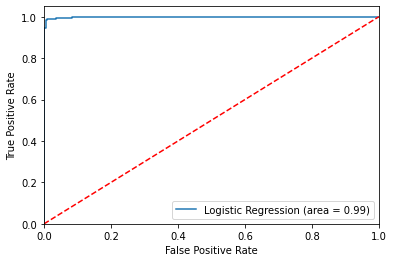

In [19]:
logit_roc_auc = roc_auc_score(val_label, classifier.predict(validation))
fpr, tpr, thresholds = roc_curve(val_label, classifier.predict_proba(validation)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [24]:
print(classification_report(classifier.predict(testing), test_label))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       0.99      1.00      1.00       198

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

